In [1]:
# DataFrame
import pandas as pd
import numpy as np

# Matplot
import matplotlib.pyplot as plt

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [2]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
dataset = pd.read_csv('/content/gdrive/MyDrive/Kaggle_Projects/Twitter sentiment analysis/training.1600000.processed.noemoticon.csv', 
                      encoding ='ISO-8859-1', names = ["target", "ids", "date", "flag", "user", "text"])

In [5]:
dataset.head(10)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
5,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
6,0,1467811592,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,mybirch,Need a hug
7,0,1467811594,Mon Apr 06 22:20:03 PDT 2009,NO_QUERY,coZZ,@LOLTrish hey long time no see! Yes.. Rains a...
8,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
9,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?


In [6]:
dataset["text"][2]

'@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds'

In [7]:
print('Dataset length: ',len(dataset))

Dataset length:  1600000


In [8]:
decode_map = {0:'Negative', 2:'Neutral', 4:'Positive'}
def decode_sentiment(label):
  return decode_map[int(label)]

In [9]:
dataset.target = dataset.target.apply(lambda x: decode_sentiment(x))

Text(0.5, 1.0, 'Dataset Labels distribution')

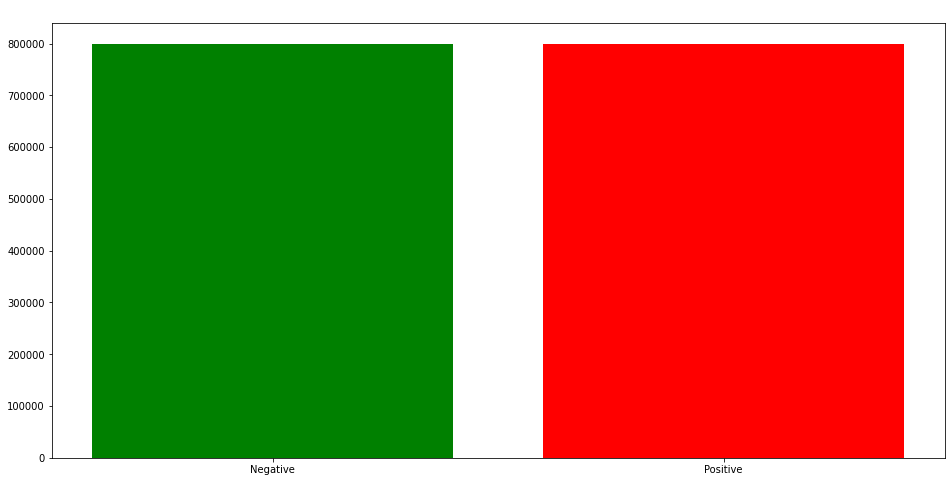

In [10]:
target_count = Counter(dataset.target)

plt.figure(figsize = (16,8))
plt.bar(target_count.keys(), target_count.values(), color = ('g','r'))
plt.title('Dataset Labels distribution', color = 'white')


## Pre-processing Data

In [11]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [12]:
text_cleaning_replacement = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"



In [13]:
s = dataset.text[0]
s

"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"

In [14]:
text_1 = re.sub(text_cleaning_replacement,' ', str(s).lower()).strip()
text_1

'awww that s a bummer you shoulda got david carr of third day to do it d'

text_cleaning_replacement = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+" 
meaning:
starting with @, '\S' means ignoring whitespace,'+' means one or more occurance, | means either or , ?: means "**A non-capturing version of regular parentheses. Matches whatever regular expression is inside the parentheses, but the substring matched by the group cannot be retrieved after performing a match or referenced later in the pattern."**
[^A-Za-z0-9] means **include all the test starting with A-z or a-z or 0-9**
so what the whole thing means is, delete everything '@' and letters adjacent to it without space, with 'https'and letters adjacent to it without space and  delete every special character and only return alphabets and numbers

In the given example :

'@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D'

@switchfoot will be deleted coz it will there is no space after @, link will be deleted coz no space after https.

in the next line **re.sub(text_cleaning_replacement,' ', str(s).lower()).strip()**
re.sub replaces the string with space using that regex code so they used str(text).lower and what .strip() does is it removes the ending and starting white spaces are removed...we are replacing the extra characters with space ... a lot of space is made in the beginning. 

In [15]:
text_cleaning_replacement = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem = False):
  text = re.sub(text_cleaning_replacement, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return ' '.join(tokens)

dataset.text = dataset.text.apply(lambda x:preprocess(x))  

## Train and test splitting

In [16]:
dataset_train, dataset_test = train_test_split(dataset, test_size = 0.2)
print('Train size:',len(dataset_train))
print('Test size:',len(dataset_test))

Train size: 1280000
Test size: 320000


In [17]:
documents = [text.split() for text in dataset_train.text]

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(size = 300, window = 7, min_count = 32, workers = 8)
w2v_model.build_vocab(documents)

2020-12-25 00:59:56,321 : INFO : collecting all words and their counts
2020-12-25 00:59:56,322 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-12-25 00:59:56,349 : INFO : PROGRESS: at sentence #10000, processed 72150 words, keeping 13952 word types
2020-12-25 00:59:56,366 : INFO : PROGRESS: at sentence #20000, processed 145054 words, keeping 21587 word types
2020-12-25 00:59:56,388 : INFO : PROGRESS: at sentence #30000, processed 217658 words, keeping 27723 word types
2020-12-25 00:59:56,405 : INFO : PROGRESS: at sentence #40000, processed 289372 words, keeping 32915 word types
2020-12-25 00:59:56,428 : INFO : PROGRESS: at sentence #50000, processed 361640 words, keeping 37723 word types
2020-12-25 00:59:56,447 : INFO : PROGRESS: at sentence #60000, processed 433376 words, keeping 42216 word types
2020-12-25 00:59:56,466 : INFO : PROGRESS: at sentence #70000, processed 504510 words, keeping 46259 word types
2020-12-25 00:59:56,487 : INFO : PROGRESS: at s

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print('Vocan size: ', vocab_size)

Vocan size:  14800


In [20]:
w2v_model.train(documents, total_examples = len(documents), epochs = 32)

2020-12-25 01:00:01,803 : INFO : training model with 8 workers on 14800 vocabulary and 300 features, using sg=0 hs=0 sample=0.001 negative=5 window=7
2020-12-25 01:00:02,825 : INFO : EPOCH 1 - PROGRESS: at 5.74% examples, 452702 words/s, in_qsize 16, out_qsize 0
2020-12-25 01:00:03,832 : INFO : EPOCH 1 - PROGRESS: at 11.91% examples, 469573 words/s, in_qsize 14, out_qsize 1
2020-12-25 01:00:04,851 : INFO : EPOCH 1 - PROGRESS: at 17.86% examples, 467561 words/s, in_qsize 16, out_qsize 1
2020-12-25 01:00:05,860 : INFO : EPOCH 1 - PROGRESS: at 24.48% examples, 480587 words/s, in_qsize 15, out_qsize 0
2020-12-25 01:00:06,863 : INFO : EPOCH 1 - PROGRESS: at 30.23% examples, 475408 words/s, in_qsize 16, out_qsize 0
2020-12-25 01:00:07,864 : INFO : EPOCH 1 - PROGRESS: at 36.39% examples, 477700 words/s, in_qsize 15, out_qsize 0
2020-12-25 01:00:08,869 : INFO : EPOCH 1 - PROGRESS: at 42.58% examples, 479071 words/s, in_qsize 15, out_qsize 1
2020-12-25 01:00:09,870 : INFO : EPOCH 1 - PROGRESS: 

(253856161, 295303616)

In [21]:
w2v_model.most_similar('love')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.
2020-12-25 01:08:21,882 : INFO : precomputing L2-norms of word weight vectors


[('luv', 0.5814796090126038),
 ('loves', 0.5744795203208923),
 ('adore', 0.5333269238471985),
 ('loved', 0.5250876545906067),
 ('amazing', 0.5048558115959167),
 ('looove', 0.497437059879303),
 ('lovee', 0.4951513707637787),
 ('loove', 0.4872170686721802),
 ('loooove', 0.46774303913116455),
 ('ilove', 0.4509035646915436)]

## Tokenize text

In [22]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(dataset_train.text)
vocab_size = len(tokenizer.word_index) + 1
print('Total words = ', vocab_size)

Total words =  290687


In [23]:
x_train = pad_sequences(tokenizer.texts_to_sequences(dataset_train.text), maxlen = 300)
x_test = pad_sequences(tokenizer.texts_to_sequences(dataset_test.text), maxlen = 300)

### Label Encoder

In [24]:
labels = dataset_train.target.unique().tolist()
labels.append('Neutral')
labels

['Negative', 'Positive', 'Neutral']

In [25]:
encoder = LabelEncoder()
encoder.fit(dataset_train.target.tolist())

y_train = encoder.transform(dataset_train.target.tolist())
y_test = encoder.transform(dataset_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (1280000, 1)
y_test shape: (320000, 1)


In [26]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1280000, 300)
y_train shape: (1280000, 1)
x_test shape: (320000, 300)
y_test shape: (320000, 1)


### Embedding Layer

In [27]:
embedding_matrix = np.zeros((vocab_size, 300))
for word in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290687, 300)


In [28]:
embedding_layer = Embedding(vocab_size, 300, weights = [embedding_matrix], input_length = 300, trainable = False)


## Building the model

In [29]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))
model.add(Dense(1, activation = 'sigmoid'))

model.summary()

2020-12-25 01:09:04,172 : WARNING : Layer lstm will not use cuDNN kernel since it doesn't meet the cuDNN kernel criteria. It will use generic GPU kernel as fallback when running on GPU


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 300, 300)          87206100  
_________________________________________________________________
dropout (Dropout)            (None, 300, 300)          0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 87,366,601
Trainable params: 160,501
Non-trainable params: 87,206,100
_________________________________________________________________


Notes: 



*   https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM
*   https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense



In [30]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

https://keras.io/api/models/model_training_apis/

**Compile method:**

Configures the model for training.

Model.compile(
    optimizer="rmsprop",
    loss=None,
    metrics=None,
    loss_weights=None,
    weighted_metrics=None,
    run_eagerly=None,
    steps_per_execution=None,
    **kwargs
)

Arguments

1. optimizer: String (name of optimizer) or optimizer instance. See tf.keras.optimizers.


2. loss: String (name of objective function), objective function or tf.keras.losses.Loss instance. See tf.keras.losses. An objective function is any callable with the signature loss = fn(y_true, y_pred), where y_true = ground truth values with shape = [batch_size, d0, .. dN], except sparse loss functions such as sparse categorical crossentropy where shape = [batch_size, d0, .. dN-1]. y_pred = predicted values with shape = [batch_size, d0, .. dN]. It returns a weighted loss float tensor. If a custom Loss instance is used and reduction is set to NONE, return value has the shape [batch_size, d0, .. dN-1] ie. per-sample or per-timestep loss values; otherwise, it is a scalar. If the model has multiple outputs, you can use a different loss on each output by passing a dictionary or a list of losses. The loss value that will be minimized by the model will then be the sum of all individual losses.


3. metrics: List of metrics to be evaluated by the model during training and testing. Each of this can be a string (name of a built-in function), function or a tf.keras.metrics.Metric instance. See tf.keras.metrics. Typically you will use metrics=['accuracy']. A function is any callable with the signature result = fn(y_true, y_pred). To specify different metrics for different outputs of a multi-output model, you could also pass a dictionary, such as metrics={'output_a': 'accuracy', 'output_b': ['accuracy', 'mse']}. You can also pass a list (len = len(outputs)) of lists of metrics such as metrics=[['accuracy'], ['accuracy', 'mse']] or metrics=['accuracy', ['accuracy', 'mse']]. When you pass the strings 'accuracy' or 'acc', we convert this to one of tf.keras.metrics.BinaryAccuracy, tf.keras.metrics.CategoricalAccuracy, tf.keras.metrics.SparseCategoricalAccuracy based on the loss function used and the model output shape. We do a similar conversion for the strings 'crossentropy' and 'ce' as well.


4. loss_weights: Optional list or dictionary specifying scalar coefficients (Python floats) to weight the loss contributions of different model outputs. The loss value that will be minimized by the model will then be the weighted sum of all individual losses, weighted by the loss_weights coefficients. If a list, it is expected to have a 1:1 mapping to the model's outputs. If a dict, it is expected to map output names (strings) to scalar coefficients.


5. weighted_metrics: List of metrics to be evaluated and weighted by sample_weight or class_weight during training and testing.


6. run_eagerly: Bool. Defaults to False. If True, this Model's logic will not be wrapped in a tf.function. Recommended to leave this as None unless your Model cannot be run inside a tf.function.


7. steps_per_execution: Int. Defaults to 1. The number of batches to run during each tf.function call. Running multiple batches inside a single tf.function call can greatly improve performance on TPUs or small models with a large Python overhead. At most, one full epoch will be run each execution. If a number larger than the size of the epoch is passed, the execution will be truncated to the size of the epoch. Note that if steps_per_execution is set to N, Callback.on_batch_begin and Callback.on_batch_end methods will only be called every N batches (i.e. before/after each tf.function execution).
**kwargs: Arguments supported for backwards compatibility only.

Raises ValueError: In case of invalid arguments for optimizer, loss or metrics.


In [31]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

Notes:


*   https://keras.io/api/callbacks/
*   https://keras.io/api/callbacks/reduce_lr_on_plateau/

Callbacks: A callback is an object that can perform actions at various stages of training (e.g. at the start or end of an epoch, before or after a single batch, etc).
You can use callbacks to:




*   Write TensorBoard logs after every batch of training to monitor your metrics 
*   Periodically save your model to disk
*   Do early stopping
*   Get a view on internal states and statistics of a model during training
...and more

**ReduceLROnPlateau**: 

Reduce learning rate when a metric has stopped improving. Models often benefit from reducing the learning rate by a factor of 2-10 once learning stagnates. This callback monitors a quantity and if no improvement is seen for a 'patience' number of epochs, the learning rate is reduced.

tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=10,
    verbose=0,
    mode="auto",
    min_delta=0.0001,
    cooldown=0,
    min_lr=0,
    **kwargs
)


 **Arguments**

1. monitor: quantity to be monitored.
2. factor: factor by which the learning rate will be reduced. new_lr = lr * factor.
3. patience: number of epochs with no improvement after which learning rate will be reduced.
4. verbose: int. 0: quiet, 1: update messages.
5. mode: one of {'auto', 'min', 'max'}. In 'min' mode, the learning rate will be reduced when the quantity monitored has stopped decreasing; in 'max' mode it will be reduced when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.
6. min_delta: threshold for measuring the new optimum, to only focus on significant changes.
7. cooldown: number of epochs to wait before resuming normal operation after lr has been reduced.
8. min_lr: lower bound on the learning rate.


https://keras.io/api/callbacks/early_stopping/

**EarlyStopping**:

Stop training when a monitored metric has stopped improving.

Assuming the goal of a training is to minimize the loss. With this, the metric to be monitored would be 'loss', and mode would be 'min'. A model.fit() training loop will check at end of every epoch whether the loss is no longer decreasing, considering the min_delta and patience if applicable. Once it's found no longer decreasing, model.stop_training is marked True and the training terminates.

The quantity to be monitored needs to be available in logs dict. To make it so, pass the loss or metrics at model.compile().

tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=0,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
)


**Arguments**

1. monitor: Quantity to be monitored.
2. min_delta: Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
3. patience: Number of epochs with no improvement after which training will be stopped.
4. verbose: verbosity mode.
5. mode: One of {"auto", "min", "max"}. In min mode, training will stop when the quantity monitored has stopped decreasing; in "max" mode it will stop when the quantity monitored has stopped increasing; in "auto" mode, the direction is automatically inferred from the name of the monitored quantity.
6. baseline: Baseline value for the monitored quantity. Training will stop if the model doesn't show improvement over the baseline.
7. restore_best_weights: Whether to restore model weights from the epoch with the best value of the monitored quantity. If False, the model weights obtained at the last step of training are used.

In [32]:
history = model.fit(x_train, y_train, batch_size = 1024, epochs = 8, validation_split = 0.1, verbose = 1, callbacks = callbacks)

Epoch 1/8
1125/1125 [==============================] - 618s 546ms/step - loss: 0.6932 - accuracy: 0.5014 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 2/8
1125/1125 [==============================] - 614s 546ms/step - loss: 0.6932 - accuracy: 0.4995 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 3/8
1125/1125 [==============================] - 614s 546ms/step - loss: 0.6932 - accuracy: 0.4999 - val_loss: 0.6932 - val_accuracy: 0.5003
Epoch 4/8
1125/1125 [==============================] - 616s 548ms/step - loss: 0.6932 - accuracy: 0.4989 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 5/8
1125/1125 [==============================] - 615s 546ms/step - loss: 0.6932 - accuracy: 0.4998 - val_loss: 0.6932 - val_accuracy: 0.4997
Epoch 6/8
1125/1125 [==============================] - 614s 546ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.4997
Epoch 7/8
1125/1125 [==============================] - 616s 548ms/step - loss: 0.6931 - accuracy: 0.4995 - val_loss: 0

https://keras.io/api/models/model_training_apis/

**Fit method**:

Trains the model for a fixed number of epochs (iterations on a dataset).

Model.fit(
    x=None,
    y=None,
    batch_size=None,
    epochs=1,
    verbose=1,
    callbacks=None,
    validation_split=0.0,
    validation_data=None,
    shuffle=True,
    class_weight=None,
    sample_weight=None,
    initial_epoch=0,
    steps_per_epoch=None,
    validation_steps=None,
    validation_batch_size=None,
    validation_freq=1,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
)

Arguments

1. x: Input data. It could be:
A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
A dict mapping input names to the corresponding array/tensors, if the model has named inputs.
A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).
A generator or keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample_weights). A more detailed description of unpacking behavior for iterator types (Dataset, generator, Sequence) is given below.


2. y: Target data. Like the input data x, it could be either Numpy array(s) or TensorFlow tensor(s). It should be consistent with x (you cannot have Numpy inputs and tensor targets, or inversely). If x is a dataset, generator, or keras.utils.Sequence instance, y should not be specified (since targets will be obtained from x).


3. batch_size: Integer or None. Number of samples per gradient update. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches).


4. epochs: Integer. Number of epochs to train the model. An epoch is an iteration over the entire x and y data provided. Note that in conjunction with initial_epoch, epochs is to be understood as "final epoch". The model is not trained for a number of iterations given by epochs, but merely until the epoch of index epochs is reached.


5. verbose: 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. Note that the progress bar is not particularly useful when logged to a file, so verbose=2 is recommended when not running interactively (eg, in a production environment).


6. callbacks: List of keras.callbacks.Callback instances. List of callbacks to apply during training. See tf.keras.callbacks. Note tf.keras.callbacks.ProgbarLogger and tf.keras.callbacks.History callbacks are created automatically and need not be passed into model.fit. tf.keras.callbacks.ProgbarLogger is created or not based on verbose argument to model.fit.


7. validation_split: Float between 0 and 1. Fraction of the training data to be used as validation data. The model will set apart this fraction of the training data, will not train on it, and will evaluate the loss and any model metrics on this data at the end of each epoch. The validation data is selected from the last samples in the x and y data provided, before shuffling. This argument is not supported when x is a dataset, generator or keras.utils.Sequence instance.


8. validation_data: Data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data. Thus, note the fact that the validation loss of data provided using validation_split or validation_data is not affected by regularization layers like noise and dropout. validation_data will override validation_split. validation_data could be: - tuple (x_val, y_val) of Numpy arrays or tensors - tuple (x_val, y_val, val_sample_weights) of Numpy arrays - dataset For the first two cases, batch_size must be provided. For the last case, validation_steps could be provided. Note that validation_data does not support all the data types that are supported in x, eg, dict, generator or keras.utils.Sequence.


9. shuffle: Boolean (whether to shuffle the training data before each epoch) or str (for 'batch'). This argument is ignored when x is a generator. 'batch' is a special option for dealing with the limitations of HDF5 data; it shuffles in batch-sized chunks. Has no effect when steps_per_epoch is not None.


10. class_weight: Optional dictionary mapping class indices (integers) to a weight (float) value, used for weighting the loss function (during training only). This can be useful to tell the model to "pay more attention" to samples from an under-represented class.


11. sample_weight: Optional Numpy array of weights for the training samples, used for weighting the loss function (during training only). You can either pass a flat (1D) Numpy array with the same length as the input samples (1:1 mapping between weights and samples), or in the case of temporal data, you can pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample. This argument is not supported when x is a dataset, generator, or keras.utils.Sequence instance, instead provide the sample_weights as the third element of x.


12. initial_epoch: Integer. Epoch at which to start training (useful for resuming a previous training run).


13. steps_per_epoch: Integer or None. Total number of steps (batches of samples) before declaring one epoch finished and starting the next epoch. When training with input tensors such as TensorFlow data tensors, the default None is equal to the number of samples in your dataset divided by the batch size, or 1 if that cannot be determined. If x is a tf.data dataset, and 'steps_per_epoch' is None, the epoch will run until the input dataset is exhausted. When passing an infinitely repeating dataset, you must specify the steps_per_epoch argument. This argument is not supported with array inputs.


14. validation_steps: Only relevant if validation_data is provided and is a tf.data dataset. Total number of steps (batches of samples) to draw before stopping when performing validation at the end of every epoch. If 'validation_steps' is None, validation will run until the validation_data dataset is exhausted. In the case of an infinitely repeated dataset, it will run into an infinite loop. If 'validation_steps' is specified and only part of the dataset will be consumed, the evaluation will start from the beginning of the dataset at each epoch. This ensures that the same validation samples are used every time.


15. validation_batch_size: Integer or None. Number of samples per validation batch. If unspecified, will default to batch_size. Do not specify the validation_batch_size if your data is in the form of datasets, generators, or keras.utils.Sequence instances (since they generate batches)


16. validation_freq: Only relevant if validation data is provided. Integer or collections.abc.Container instance (e.g. list, tuple, etc.). If an integer, specifies how many training epochs to run before a new validation run is performed, e.g. validation_freq=2 runs validation every 2 epochs. If a Container, specifies the epochs on which to run validation, e.g. validation_freq=[1, 2, 10] runs validation at the end of the 1st, 2nd, and 10th epochs.


17. max_queue_size: Integer. Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.


18. workers: Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1. If 0, will execute the generator on the main thread.


19. use_multiprocessing: Boolean. Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. Note that because this implementation relies on multiprocessing, you should not pass non-picklable arguments to the generator as they can't be passed easily to children processes.
Unpacking behavior for iterator-like inputs: A common pattern is to pass a tf.data.Dataset, generator, or tf.keras.utils.Sequence to the x argument of fit, which will in fact yield not only features (x) but optionally targets (y) and sample weights. Keras requires that the output of such iterator-likes be unambiguous. The iterator should return a tuple of length 1, 2, or 3, where the optional second and third elements will be used for y and sample_weight respectively. Any other type provided will be wrapped in a length one tuple, effectively treating everything as 'x'. When yielding dicts, they should still adhere to the top-level tuple structure. e.g. ({"x0": x0, "x1": x1}, y). Keras will not attempt to separate features, targets, and weights from the keys of a single dict. A notable unsupported data type is the namedtuple. The reason is that it behaves like both an ordered datatype (tuple) and a mapping datatype (dict). So given a namedtuple of the form: namedtuple("example_tuple", ["y", "x"]) it is ambiguous whether to reverse the order of the elements when interpreting the value. Even worse is a tuple of the form: namedtuple("other_tuple", ["x", "y", "z"]) where it is unclear if the tuple was intended to be unpacked into x, y, and sample_weight or passed through as a single element to x. As a result the data processing code will simply raise a ValueError if it encounters a namedtuple. (Along with instructions to remedy the issue.)

Returns

A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values (if applicable).

Raises

RuntimeError: 
1. If the model was never compiled or, 
2. If model.fit is wrapped in tf.function.

ValueError: In case of mismatch between the provided input data and what the model expects or when the input data is empty.


In [33]:
score = model.evaluate(x_test, y_test, batch_size = 1024)
print('Accuracy is: ',score[1])
print('Loss is: ',score[0])

313/313 [==============================] - 60s 190ms/step - loss: 0.6931 - accuracy: 0.5002
Accuracy is:  0.5001500248908997
Loss is:  0.6931470632553101


https://keras.io/api/models/model_training_apis/

**Evaluate method**:

Returns the loss value & metrics values for the model in test mode. Computation is done in batches.

Model.evaluate(
    x=None,
    y=None,
    batch_size=None,
    verbose=1,
    sample_weight=None,
    steps=None,
    callbacks=None,
    max_queue_size=10,
    workers=1,
    use_multiprocessing=False,
    return_dict=False,
)

**Arguments**

1. x: Input data. It could be:
A Numpy array (or array-like), or a list of arrays (in case the model has multiple inputs).
A TensorFlow tensor, or a list of tensors (in case the model has multiple inputs).
A dict mapping input names to the corresponding array/tensors, if the model has named inputs.
A tf.data dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).
A generator or keras.utils.Sequence returning (inputs, targets) or (inputs, targets, sample_weights). A more detailed description of unpacking behavior for iterator types (Dataset, generator, Sequence) is given in the Unpacking behavior for iterator-like inputs section of Model.fit.


2. y: Target data. Like the input data x, it could be either Numpy array(s) or TensorFlow tensor(s). It should be consistent with x (you cannot have Numpy inputs and tensor targets, or inversely). If x is a dataset, generator or keras.utils.Sequence instance, y should not be specified (since targets will be obtained from the iterator/dataset).


3. batch_size: Integer or None. Number of samples per batch of computation. If unspecified, batch_size will default to 32. Do not specify the batch_size if your data is in the form of a dataset, generators, or keras.utils.Sequence instances (since they generate batches).


4. verbose: 0 or 1. Verbosity mode. 0 = silent, 1 = progress bar.


5. sample_weight: Optional Numpy array of weights for the test samples, used for weighting the loss function. You can either pass a flat (1D) Numpy array with the same length as the input samples (1:1 mapping between weights and samples), or in the case of temporal data, you can pass a 2D array with shape (samples, sequence_length), to apply a different weight to every timestep of every sample. This argument is not supported when x is a dataset, instead pass sample weights as the third element of x.


6. steps: Integer or None. Total number of steps (batches of samples) before declaring the evaluation round finished. Ignored with the default value of None. If x is a tf.data dataset and steps is None, 'evaluate' will run until the dataset is exhausted. This argument is not supported with array inputs.


7. callbacks: List of keras.callbacks.Callback instances. List of callbacks to apply during evaluation. See callbacks.


8. max_queue_size: Integer. Used for generator or keras.utils.Sequence input only. Maximum size for the generator queue. If unspecified, max_queue_size will default to 10.


9. workers: Integer. Used for generator or keras.utils.Sequence input only. Maximum number of processes to spin up when using process-based threading. If unspecified, workers will default to 1. If 0, will execute the generator on the main thread.


10. use_multiprocessing: Boolean. Used for generator or keras.utils.Sequence input only. If True, use process-based threading. If unspecified, use_multiprocessing will default to False. Note that because this implementation relies on multiprocessing, you should not pass non-picklable arguments to the generator as they can't be passed easily to children processes.


11. return_dict: If True, loss and metric results are returned as a dict, with each key being the name of the metric. If False, they are returned as a list.


See the discussion of Unpacking behavior for iterator-like inputs for Model.fit.

Returns

Scalar test loss (if the model has a single output and no metrics) or list of scalars (if the model has multiple outputs and/or metrics). The attribute model.metrics_names will give you the display labels for the scalar outputs.

Raises

RuntimeError: If model.evaluate is wrapped in tf.function.
ValueError: in case of invalid arguments.

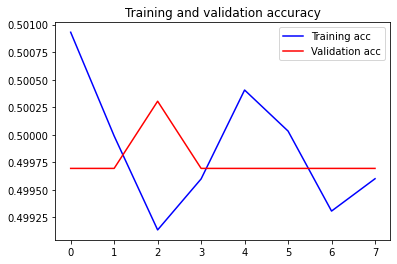

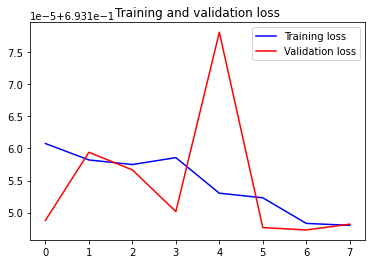

In [35]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

### Prediction

In [36]:
def decode_sentiment(score, include_neutral = True):
  if include_neutral:
    label = 'Neutral'
    if score <= 0.4:
      label = 'Negative'
    elif score >= 0.7:
      label = 'Positive'
    return label
  else:
    return 'Negative' if score < 0.5 else 'Positive'

In [46]:
def predict(text, include_neutral = True):
  #Tokenize text
  x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen = 300)
  score = model.predict([text])[0]
  label = decode_sentiment(score, include_neutral = include_neutral)

  print('label', label)
  print('score', (score))

In [47]:
predict('I do not music')


2020-12-25 02:48:24,846 : WARNING : Model was constructed with shape (None, 300) for input KerasTensor(type_spec=TensorSpec(shape=(None, 300), dtype=tf.float32, name='embedding_input'), name='embedding_input', description="created by layer 'embedding_input'"), but it was called on an input with incompatible shape (None, 1).


UnimplementedError: ignored

## Confusion Matrix

In [48]:
y_pred = []
y_test = list(dataset_train.target)
scores = model.predict(x_test, verbose = 1, batch_size = 8000)
y_pred = [decode_sentiment(score, include_neutral=False) for score in scores]

40/40 [==============================] - 50s 1s/step


In [49]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [50]:
cnf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,12))
plot_confusion_matrix(cnf_matrix, classes=dataset_train.target.unique(), title="Confusion matrix")
plt.show()

ValueError: ignored

In [51]:
print(classification_report(y_test, y_pred))

ValueError: ignored

In [52]:
accuracy_score(y_test, y_pred)

ValueError: ignored